Notebook to play around with compression schemes for a simple toy example

In [1]:
import emcee
import numpy as np 
import corner as DFM
# --- emanu---
from emanu import compressor as Comp

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Simple two parameter model with diagonal covariance

In [3]:
theta_true = np.array([0.5, 0.5])
cov_true = np.identity(20)
def model(theta): 
    return theta[0] * np.arange(20) + theta[1]
X_true = model(theta_true)

In [4]:
X_data = np.random.multivariate_normal(model(theta_true), cov_true, size=1000)
cov_data = np.cov(X_data.T)

cinv_data = np.linalg.inv(cov_data)

nmock, ndata = X_data.shape
print float(nmock - ndata - 2)/float(nmock - 1) 
cinv_data *= float(nmock - ndata - 2)/float(nmock - 1) 

0.978978978979


Here's what the data looks like

(0.0, 19.0)

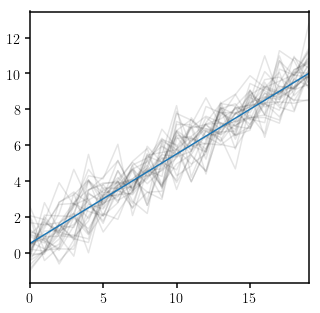

In [5]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
for _x in X_data[:30]: 
    sub.plot(_x, c='k', alpha=0.1)
sub.plot(model(theta_true))
sub.set_xlim(0., 19.)

PCA compression with different number of components

In [30]:
cmpsr0 = Comp.Compressor(method='PCA')      
cmpsr0.fit(X_data, n_components=20, whiten=False)

cmpsr1 = Comp.Compressor(method='PCA')      
cmpsr1.fit(X_data, n_components=10, whiten=False)

cmpsr2 = Comp.Compressor(method='PCA')      
cmpsr2.fit(X_data, n_components=5, whiten=False)

In [31]:
c0X_true = cmpsr0.transform(np.atleast_2d(model(theta_true)))
c1X_true = cmpsr1.transform(np.atleast_2d(model(theta_true)))
c2X_true = cmpsr2.transform(np.atleast_2d(model(theta_true)))

c0X_data = cmpsr0.transform(X_data)
c1X_data = cmpsr1.transform(X_data)
c2X_data = cmpsr2.transform(X_data)

c0cov_data = np.cov(c0X_data.T)
c1cov_data = np.cov(c1X_data.T)
c2cov_data = np.cov(c2X_data.T)

c0cinv_data = np.linalg.inv(c0cov_data) * float(c0X_data.shape[0] - c0X_data.shape[1] - 2)/float(c0X_data.shape[0] - 1) 
c1cinv_data = np.linalg.inv(c1cov_data) * float(c1X_data.shape[0] - c1X_data.shape[1] - 2)/float(c1X_data.shape[0] - 1) 
c2cinv_data = np.linalg.inv(c2cov_data) * float(c2X_data.shape[0] - c2X_data.shape[1] - 2)/float(c2X_data.shape[0] - 1) 

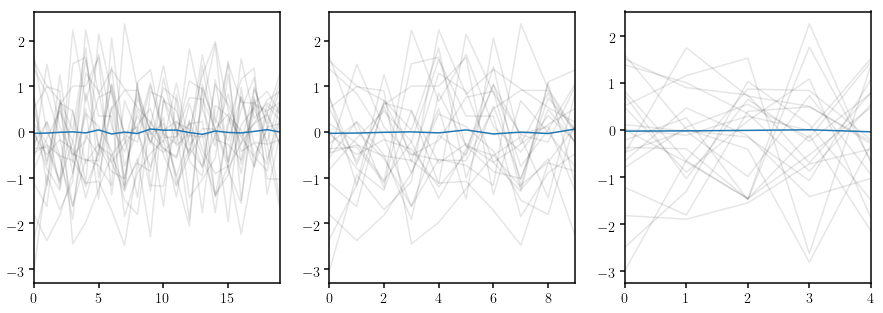

In [32]:
fig = plt.figure(figsize=(15,5))
for i, cX_data, cX_true in zip(range(3), [c0X_data, c1X_data, c2X_data], [c0X_true, c1X_true, c2X_true]): 
    sub = fig.add_subplot(1,3,i+1)
    for _cx in cX_data[:20]: 
        sub.plot(_cx, c='k', alpha=0.1)
    sub.plot(cX_true.flatten(), c='C0')
    sub.set_xlim(0., cX_data.shape[1]-1)

In [41]:
# initialize walkers randomly drawn from prior 
ndim = len(theta_true)

prior_range = np.array([[0.25, 0.75], [-0.5, 1.5]])

def lnprior(tt): 
    ''' log uniform prior. totally uninformative
    '''
    t0, t1 = tt 
    if (prior_range[0][0] <= t0 <= prior_range[0][1]) and (prior_range[1][0] <= t1 <= prior_range[1][1]):
        return 0.0 
    return -np.inf 

In [42]:
def lnlike(tt): 
    ''' log likelihood of the full data
    '''
    delta = (model(tt) - X_true) 
    return -0.5*np.dot(delta, np.dot(cinv_data, delta.T))

def lnprob(tt):
    lp = lnprior(tt)
    if not np.isfinite(lp): 
        return -np.inf 
    return lp + lnlike(tt)

In [44]:
def mcmc(lnpost, nwalkers=100, burn_in_chain=200, main_chain=1000): 
    pos = [np.random.uniform(prior_range[:,0], prior_range[:,1]) for i in range(nwalkers)]

    # run mcmc 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost)

    print('running burn-in chain') 
    pos, prob, state = sampler.run_mcmc(pos, burn_in_chain)
    sampler.reset()
    print('running main chain') 
    sampler.run_mcmc(pos, main_chain)

    # save chain 
    post = sampler.flatchain.copy() 
    return post

running burn-in chain
running main chain


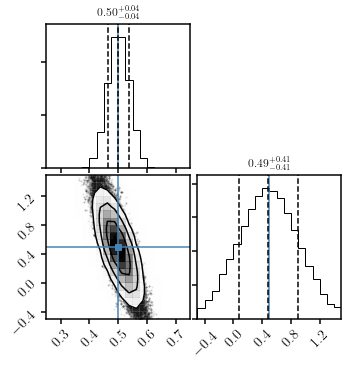

In [45]:
# save chain 
post = mcmc(lnprob)

fig = DFM.corner(post, color='k', quantiles=[0.16, 0.5, 0.84], bins=20, range=prior_range, truths=theta_true,
        smooth=True, show_titles=True, label_kwargs={'fontsize': 20}) 

In [46]:
def c0lnlike(tt): 
    ''' log likelihood of the compressed data
    '''
    cmodel = cmpsr0.transform(np.atleast_2d(model(tt)))
    delta = (cmodel.flatten() - c0X_true.flatten()) 
    return -0.5*np.dot(delta, np.dot(c0cinv_data, delta.T))

def c1lnlike(tt): 
    ''' log likelihood of the compressed data
    '''
    cmodel = cmpsr1.transform(np.atleast_2d(model(tt)))
    delta = (cmodel.flatten() - c1X_true.flatten()) 
    return -0.5*np.dot(delta, np.dot(c1cinv_data, delta.T))

def c2lnlike(tt): 
    ''' log likelihood of the compressed data
    '''
    cmodel = cmpsr2.transform(np.atleast_2d(model(tt)))
    delta = (cmodel.flatten() - c2X_true.flatten()) 
    return -0.5*np.dot(delta, np.dot(c2cinv_data, delta.T))

def c0lnprob(tt):
    lp = lnprior(tt)
    if not np.isfinite(lp): 
        return -np.inf 
    return lp + c0lnlike(tt)

def c1lnprob(tt):
    lp = lnprior(tt)
    if not np.isfinite(lp): 
        return -np.inf 
    return lp + c1lnlike(tt)

def c2lnprob(tt):
    lp = lnprior(tt)
    if not np.isfinite(lp): 
        return -np.inf 
    return lp + c2lnlike(tt)

In [47]:
# save chain 
c0post = mcmc(c0lnprob)
c1post = mcmc(c1lnprob)
c2post = mcmc(c2lnprob)

running burn-in chain
running main chain
running burn-in chain
running main chain
running burn-in chain
running main chain


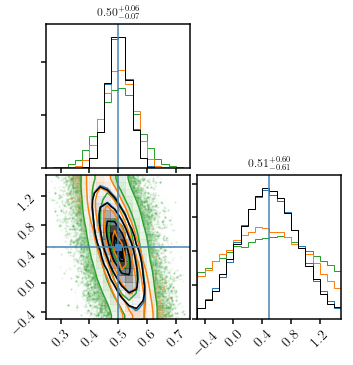

In [48]:
fig = DFM.corner(c2post, color='C2', bins=20, range=prior_range, truths=theta_true,
        smooth=True, show_titles=True, label_kwargs={'fontsize': 20}) 
fig = DFM.corner(c1post, color='C1', bins=20, range=prior_range, smooth=True, fig=fig)
fig = DFM.corner(c0post, color='C0', bins=20, range=prior_range, smooth=True, fig=fig)
fig = DFM.corner(post, color='k', bins=20, range=prior_range, smooth=True, fig=fig)